In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

# NN
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from tools.pid import PID
from tools.motor import DC_Motor as Motor
import math
import matplotlib.pyplot as plt

## Generte Data

In [2]:
# target
import json
with open('data.json') as json_file:
    data = json.load(json_file)
    
motor = Motor()
pid = PID(10, 0.1, 0.3)

xData = []
xTarget = []
yData = []
xTime = []
xResponse = []

# Create data
steps = data['target']
time = 0
for i in range(len(steps)):
    target = steps[i]
    targetR = target * math.pi / 180
    
    for millisecond in range(1000):
        time += 1
        inputData = []
        outputData = []
        
        # get the angle of the motor
        theta = motor.getRad()
        
        # log input data
        inputData += [targetR - theta]
        inputData += [pid.get_pre_error()]
        inputData += [pid.get_error_sum()]
        
        # update pid
        controlSignal = pid.update(targetR - theta)
        
        # update motor
        motor.update(controlSignal)
        
        # log output data
        outputData += [controlSignal]
        outputData += [pid.get_pre_error()]
        outputData += [pid.get_error_sum()]
        
        xTarget += [targetR]
        xTime += [time / 1000]
        xData += [inputData]
        yData += [outputData]
        xResponse += [theta]

## Response

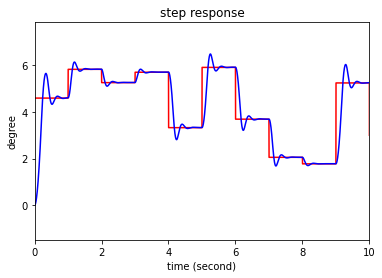

In [3]:
# draw graph
plt.plot(xTime, xTarget, color='r', label='target')
plt.plot(xTime, xResponse, color='b', label='response')
plt.xlim(0, 10)
plt.title('step response')
plt.ylabel('degree')
plt.xlabel('time (second)')
plt.show()

## Normailze Data

In [4]:
scalar_x = MinMaxScaler()
scalar_y = MinMaxScaler()
x = scalar_x.fit_transform(xData)
y = scalar_y.fit_transform(yData)

In [5]:
# Split into train and test 
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, shuffle=True)
xSize = len(xTrain[0])
ySize = len(yTrain[0])

## Model Architecture

In [6]:
# two fully connective layer
# parameters
firstLayerSize = xSize * ySize
secondLayerSize = xSize * ySize
thirdLayerSize = xSize * ySize

inputs = Input(shape=(xSize))
layer1 = Dense(firstLayerSize, activation='relu')(inputs)
layer2 = Dense(secondLayerSize, activation='relu')(layer1)
layer3 = Dense(secondLayerSize, activation='relu')(layer2)
predictions = Dense(ySize, activation='relu')(layer3)
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
model.fit(xTrain, yTrain, epochs=20)

# save training model
model.save('./model/pid_model_nn.h5')

Epoch 1/20
12500/12500 [==============================] - 6s 452us/step - loss: 0.0057
Epoch 2/20
12500/12500 [==============================] - 6s 453us/step - loss: 4.7249e-07
Epoch 3/20
12500/12500 [==============================] - 6s 452us/step - loss: 4.1514e-07
Epoch 4/20
12500/12500 [==============================] - 6s 447us/step - loss: 3.9418e-07
Epoch 5/20
12500/12500 [==============================] - 6s 447us/step - loss: 3.8009e-07
Epoch 6/20
12500/12500 [==============================] - 6s 451us/step - loss: 3.5065e-07
Epoch 7/20
12500/12500 [==============================] - 6s 451us/step - loss: 3.4253e-07
Epoch 8/20
12500/12500 [==============================] - 6s 446us/step - loss: 3.2087e-07
Epoch 9/20
12500/12500 [==============================] - 6s 449us/step - loss: 3.1338e-07
Epoch 10/20
12500/12500 [==============================] - 6s 449us/step - loss: 3.0869e-07
Epoch 11/20
12500/12500 [==============================] - 6s 445us/step - loss: 2.9964e-07
E

In [8]:
result = model.predict(xTest)
for i in range(len(result[0])):
    yt = yTest[:, i]
    yt_ = result[:, i]
    accuracy = mean_squared_error(yt, yt_)
    print(f'var{i} mean squared error: {accuracy}')

var0 mean squared error: 6.107773733654534e-08
var1 mean squared error: 1.142231208189908e-07
var2 mean squared error: 2.8935537233454735e-07


In [9]:
motor = Motor()
# pid variables
pid_pre_error = 0
pid_error_sum = 0
modelResponse = []
xTimeLen = 10

for i in range(xTimeLen):
    target = steps[i]
    targetR = target * math.pi / 180
    print(f'{i} ', end='')
    for millisecond in range(1000):
        inputData = []
        outputData = []
        
        # get the angle of the motor
        theta = motor.getRad()
        
        # input data
        inputData += [targetR - theta]
        inputData += [pid_pre_error]
        inputData += [pid_error_sum]
        _input = [inputData]
        _input = scalar_x.transform(_input)
        
        # pid model
        modelOutputNorm = model.predict(_input)
        modelOutput = scalar_y.inverse_transform(modelOutputNorm)
        
        # update model
        motor.update(modelOutput[0][0])
        pid_pre_error = modelOutput[0][1]
        pid_error_sum = modelOutput[0][2]
        
        modelResponse += [theta]

0 1 2 3 4 5 6 7 8 9 

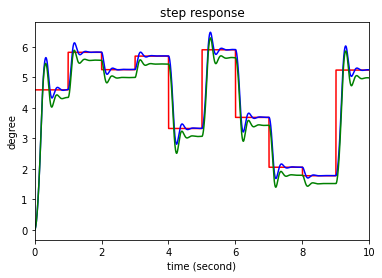

In [10]:
# draw graph
mTime = xTimeLen * 1000
plt.plot(xTime[: mTime], xTarget[: mTime], color='r', label='target')
plt.plot(xTime[: mTime], xResponse[: mTime], color='b', label='pid response')
plt.plot(xTime[: mTime], modelResponse[: mTime], color='g', label='model response')
plt.xlim(0, xTimeLen)
plt.title('step response')
plt.ylabel('degree')
plt.xlabel('time (second)')
plt.show()

In [11]:
modelResponse[1000 * 9]


1.5178805336968149

In [12]:
fileName = './data/nn-MinMaxScalar.csv'
f = open(fileName, 'w')
for i in range(mTime):
    f.write(f'{xTime[i]}\t{xTarget[i]}\t{xResponse[i]}\n')

In [13]:
model.save('./model/nn-MinMaxScalar.h5')